In [42]:
import pandas as pd
import numpy as np
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

# from imblearn.over_sampling import SMOTE

from gensim import downloader as api
from tqdm import tqdm
from nltk import word_tokenize

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

# from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline

sys.path.insert(0,"../")
from util.helpers import evaluate_score, evaluate_model

In [16]:
data_path = "../data/"
df = pd.read_csv(data_path + "cleaned_Tweets.csv", index_col=0)

yLabels = ["neg", "neu", "pos"]

In [17]:
vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.9999, ngram_range=(1,3), max_features=10000)
X = vectorizer.fit_transform(df.text)

scaler = StandardScaler(with_mean=False)
scaler.fit(X)

xTrain, xTest, yTrain, yTest = train_test_split(X, df.airline_sentiment, train_size=0.8, stratify=df.airline_sentiment)

              precision    recall  f1-score   support

          -1       0.82      0.93      0.87      1835
           0       0.68      0.50      0.57       620
           1       0.74      0.64      0.69       473

    accuracy                           0.79      2928
   macro avg       0.75      0.69      0.71      2928
weighted avg       0.78      0.79      0.78      2928



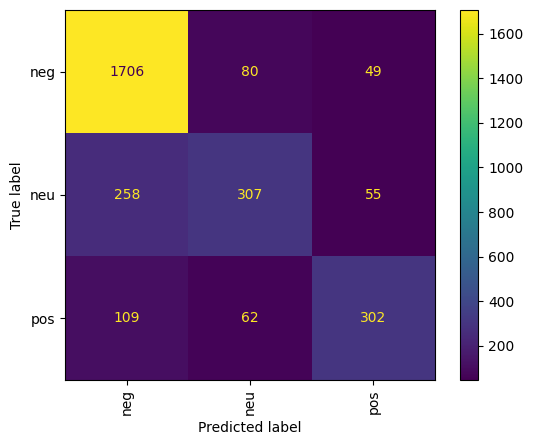

In [22]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xTrain), yTrain)

yPred = evaluate_model(clf, xTest, yTest, yLabels)

              precision    recall  f1-score   support

          -1       0.85      0.92      0.88      1835
           0       0.69      0.56      0.62       620
           1       0.74      0.69      0.71       473

    accuracy                           0.80      2928
   macro avg       0.76      0.72      0.74      2928
weighted avg       0.80      0.80      0.80      2928



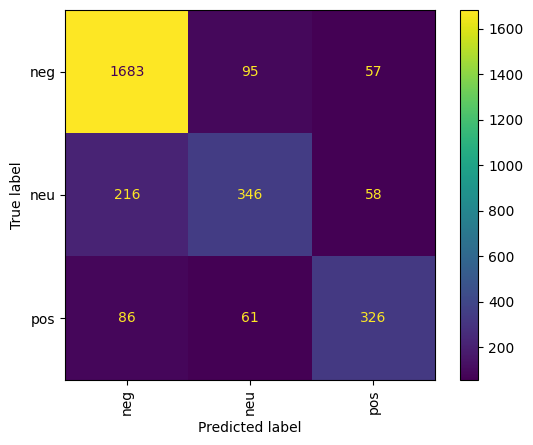

In [23]:
clf = LinearSVC()
clf.fit(xTrain, yTrain)

yPred = evaluate_model(clf, xTest, yTest, yLabels)

In [24]:
wv = api.load('word2vec-google-news-300')

def make_avg_embeds(data):
    
    embeds = []

    for rev in tqdm(data.text):
        vec = []
        tokens = word_tokenize(rev)
        
        for tok in tokens:
            try:
                wordVec = wv[tok]
                vec.append(wordVec.tolist())
            except:
                pass
            
        
        vec = np.asarray(vec)
        vec = vec.mean(axis=0)
        
        embeds.append(pd.Series(vec))

    embeds = pd.concat(embeds, axis=1).transpose()
    embeds = embeds.fillna(0)
    return embeds

In [25]:
embeds = make_avg_embeds(df)
xTrain, xTest, yTrain, yTest = train_test_split(embeds, df.airline_sentiment, train_size=0.8, stratify=df.airline_sentiment)

 41%|████      | 5973/14640 [00:02<00:03, 2399.36it/s]C:\Users\Jonny\AppData\Local\Temp\ipykernel_11324\2688462465.py:20: RuntimeWarning: Mean of empty slice.
  vec = vec.mean(axis=0)
c:\Users\Jonny\USC\Natural Language Processing\natalies-little-helper\nlh\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 14640/14640 [00:06<00:00, 2110.44it/s]


              precision    recall  f1-score   support

          -1       0.79      0.95      0.86      1835
           0       0.66      0.42      0.51       620
           1       0.81      0.58      0.68       473

    accuracy                           0.78      2928
   macro avg       0.75      0.65      0.68      2928
weighted avg       0.77      0.78      0.76      2928



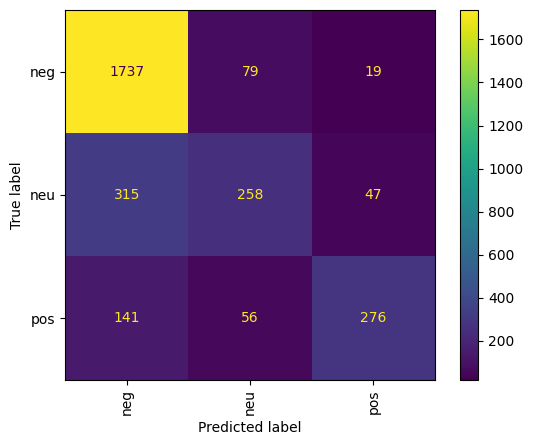

In [26]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
# clf.fit(scaler.transform(xTrain), yTrain)
clf.fit(xTrain, yTrain)

yPred = evaluate_model(clf, xTest, yTest, yLabels)

              precision    recall  f1-score   support

          -1       0.82      0.94      0.88      1835
           0       0.66      0.48      0.55       620
           1       0.80      0.63      0.71       473

    accuracy                           0.79      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928



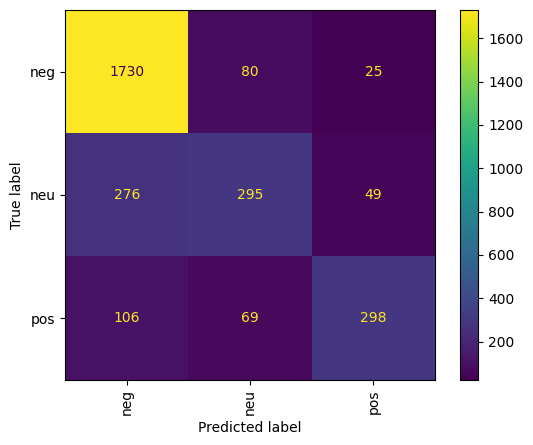

In [27]:
clf = LinearSVC()
clf.fit(xTrain, yTrain)

yPred = evaluate_model(clf, xTest, yTest, yLabels)

In [42]:
wordvec = pd.concat([df.airline_sentiment, pd.DataFrame(embeds, columns=range(300))], axis=1)
wordvec.columns = range(301)

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
class FNN(nn.Module):
    
    def __init__(self, in_size):
        super(FNN, self).__init__()
        
        h1 = 50
        h2 = 10
        
        self.fc1 = nn.Linear(in_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 3)
        
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x

class WordVecData(Dataset):
    
    def __init__(self, data) -> None:
        super(WordVecData, self).__init__()
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        feature = self.data[idx, 1:]
        label = int(self.data[idx, 0]) + 1
        
        return feature, label

In [45]:
train, test = train_test_split(wordvec, test_size=0.2, stratify=wordvec.iloc[:,0])

train = torch.tensor(train.to_numpy(), device=device, dtype=torch.float, requires_grad=True)
test = torch.tensor(test.to_numpy(), device=device, dtype=torch.float, requires_grad=False)

num_train = len(train)
indices = list(range(num_train))
np.random.shuffle(indices)
cap = int(np.floor(0.2 * num_train))

train_idx, valid_idx = indices[cap:], indices[:cap]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_data = WordVecData(train)
test_data = WordVecData(test)

train_loader = DataLoader(train_data, batch_size=16, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=16, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=1)

In [ ]:
model = FNN(300)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.to(device)
criterion.to(device)

n_epochs = 50

valid_loss_min = np.Inf

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()

    for data, target in train_loader:

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target.to(device))
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    
    model.eval()

    for data, target in valid_loader:
        
        output = model(data)
        loss = criterion(output, target.to(device))
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '../models/model.pt')
        valid_loss_min = valid_loss

In [47]:
yTest = [int(vec[0]) for vec in test]

model = FNN(300)
model.load_state_dict(torch.load("../models/model_sent_78.pt"))
model.to(device)
model.eval()

preds = []

with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = model(data)
        preds.append(int(output[0].argmax()) - 1)
        # print(output[0], " | ", int(output[0].argmax()), ":", int(target))


evaluate_score(yTest, preds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2928/2928 [00:01<00:00, 2197.00it/s]

Accuracy:	 0.7858606557377049
Precision:	 [0.81770335 0.66129032 0.7549505 ]
Recall: 	 [0.93133515 0.46290323 0.6448203 ]
F1 scores:	 [0.87082803 0.54459203 0.69555302]
Average
	Precision: 0.7744457753044501
	Recall: 0.7858606557377049
	F1: 0.7734334237781955


In [ ]:
df_tok = pd.read_csv(data_path + "Tweets.csv")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", Truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [49]:
data_og = pd.concat([df_tok.text, df_tok.airline_sentiment], axis=1)

data = []
for t in data_og.iterrows():
    temp = {}
    temp["text"] = t[1].text
    temp["label"] = 0 if t[1].airline_sentiment == "negative" else 1 if  t[1].airline_sentiment == "neutral" else 2
    temp.update(tokenizer(t[1].text))
    data.append(temp)

train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [50]:
data = []
for t in data_og.iterrows():
    temp = {}
    temp["text"] = t[1].text
    temp["label"] = 0 if t[1].airline_sentiment == "negative" else 1
    temp.update(tokenizer(t[1].text))
    data.append(temp)

trainBinary, testBinary = train_test_split(data, test_size=0.2)
trainBinary, valBinary = train_test_split(trainBinary, test_size=0.2)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="../results",
    learning_rate=2e-5,
    evaluation_strategy = "steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

In [ ]:
preds = trainer.predict(test)

yTest = [t["label"] for t in test]
yPred = [p.argmax() for p in preds[0]]
evaluate_score(yTest, yPred)

In [ ]:
trainer.model.save_pretrained("../models/tuned_distilbert_sentiment")

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="../results",
    learning_rate=2e-5,
    evaluation_strategy = "steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=trainBinary,
    eval_dataset=valBinary,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

In [ ]:
preds = trainer.predict(testBinary)

yTest = [t["label"] for t in testBinary]
yPred = [p.argmax() for p in preds[0]]
evaluate_score(yTest, yPred)

In [ ]:
trainer.model.save_pretrained("../models/tuned_binary_distilbert")

Accuracy:	 0.8555327868852459
Precision:	 [0.86901271 0.7920354  0.85813953]
Recall: 	 [0.96212121 0.60370995 0.75770021]
F1 scores:	 [0.91319979 0.68516746 0.80479826]
Average
	Precision: 0.8516142173872208
	Recall: 0.8555327868852459
	F1: 0.8489871164042715


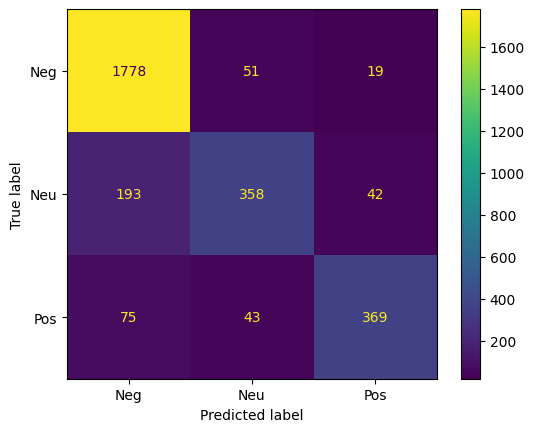

In [60]:
saved_model = "../models/tuned_distilbert_sentiment"

tuned_model = AutoModelForSequenceClassification.from_pretrained(saved_model, num_labels=3)
clf = pipeline("text-classification", model=tuned_model, tokenizer=AutoTokenizer.from_pretrained("distilbert-base-uncased", Truncation=True))

test_set = [{k: v for k,v in t.items() if k == "text"} for t in test]
preds = clf(test_set)

label_map = {"LABEL_0":0,"LABEL_1":1,"LABEL_2":2}
yPred = [label_map[v] for t in preds for k,v in t.items() if k == "label" ]
yTest = [t["label"] for t in test]

evaluate_score(yTest, yPred)
ConfusionMatrixDisplay.from_predictions(yTest, yPred, display_labels=["Neg", "Neu", "Pos"])

Accuracy:	 0.8722677595628415
Precision:	 [0.89795918 0.82739212]
Recall: 	 [0.90086207 0.82276119]
F1 scores:	 [0.89940828 0.82507016]
Average
	Precision: 0.8721231549243201
	Recall: 0.8722677595628415
	F1: 0.8721915934511647


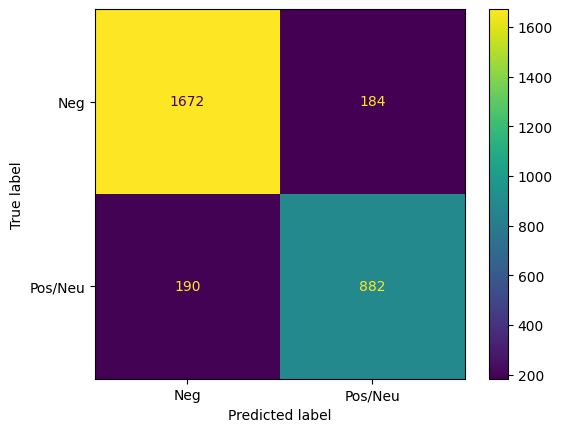

In [59]:
saved_model = "../models/tuned_binary_distilbert"

tuned_model = AutoModelForSequenceClassification.from_pretrained(saved_model, num_labels=2)
clf = pipeline("text-classification", model=tuned_model, tokenizer=AutoTokenizer.from_pretrained("distilbert-base-uncased", Truncation=True))

test_set = [{k: v for k,v in t.items() if k == "text"} for t in testBinary]
preds = clf(test_set)

label_map = {"LABEL_0":0,"LABEL_1":1}
yPred = [label_map[v] for t in preds for k,v in t.items() if k == "label" ]
yTest = [t["label"] for t in testBinary]

evaluate_score(yTest, yPred)
ConfusionMatrixDisplay.from_predictions(yTest, yPred, display_labels=["Neg", "Pos/Neu"])